In [1]:
import pandas as pd

df = pd.read_csv("expenses.csv")  # replace with your file name
df.head()


,Date,Description,Category,Amount
0,2025-01-02,Groceries at market,Food,35
1,2025-01-03,Bus fare,Transport,5
2,2025-01-05,Mobile data,Utilities,10
3,2025-01-07,Restaurant,Food,22
4,2025-01-10,Movie night,Entertainment,15


## Preparing the data

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')

df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df = df.dropna(subset=['Amount'])
df = df[df['Amount'] > 0]

df.head()


,Date,Description,Category,Amount,Month
0,2025-01-02,Groceries at market,Food,35,2025-01
1,2025-01-03,Bus fare,Transport,5,2025-01
2,2025-01-05,Mobile data,Utilities,10,2025-01
3,2025-01-07,Restaurant,Food,22,2025-01
4,2025-01-10,Movie night,Entertainment,15,2025-01


# Spending by catergory

In [5]:
category_sum = df.groupby('Category')['Amount'].sum().sort_values(ascending=False)
category_sum


Category
Food             349
Education        145
Utilities        123
Transport         57
Entertainment     43
Name: Amount, dtype: int64

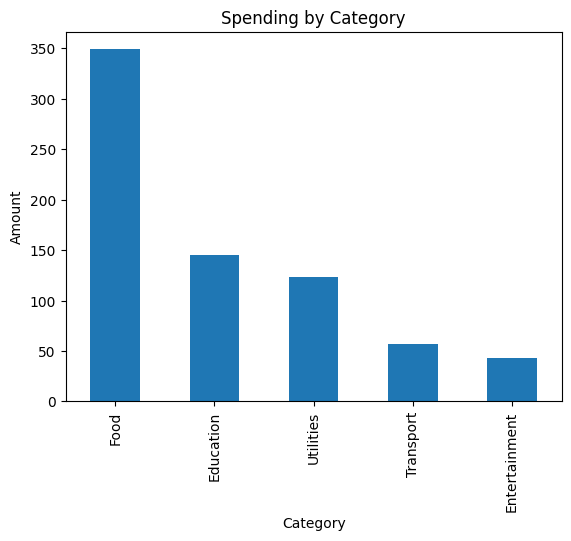

In [6]:
import matplotlib.pyplot as plt

category_sum.plot(kind='bar')
plt.title("Spending by Category")
plt.ylabel("Amount")
plt.show()


# Monthly spending

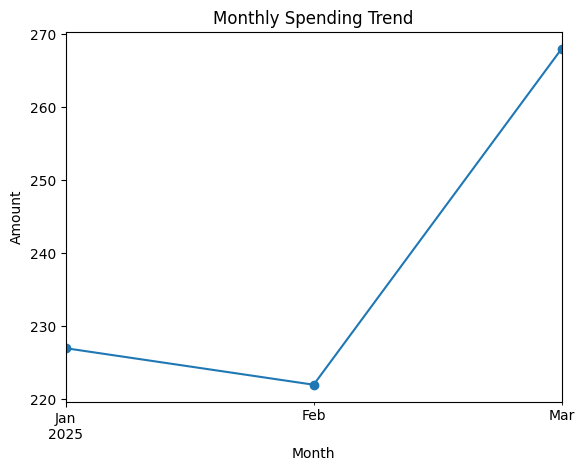

In [7]:
monthly_sum = df.groupby('Month')['Amount'].sum()

monthly_sum.plot(kind='line', marker='o')
plt.title("Monthly Spending Trend")
plt.ylabel("Amount")
plt.show()


# CLUSTERING SPENDING PATTERNS (KMEANS)

In [8]:
# Create Monthly Category Spending Table
monthly_cat = df.groupby(['Month', 'Category'])['Amount'].sum().unstack().fillna(0)
monthly_cat


Category,Education,Entertainment,Food,Transport,Utilities
Month,,,,,
2025-01,50,15,105,17,40
2025-02,35,10,117,20,40
2025-03,60,18,127,20,43


In [9]:
# Scaling the Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(monthly_cat)


In [10]:
# Apply KMeans Clustering

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

monthly_cat['Cluster'] = clusters
monthly_cat


Category,Education,Entertainment,Food,Transport,Utilities,Cluster
Month,,,,,,
2025-01,50,15,105,17,40,2
2025-02,35,10,117,20,40,0
2025-03,60,18,127,20,43,1


In [11]:
cluster_summary = monthly_cat.groupby('Cluster').mean()
cluster_summary


Category,Education,Entertainment,Food,Transport,Utilities
Cluster,,,,,
0,35.0,10.0,117.0,20.0,40.0
1,60.0,18.0,127.0,20.0,43.0
2,50.0,15.0,105.0,17.0,40.0


In [13]:
# Labeling the clusters

cluster_names = {
    0: "Saver",
    1: "High Spender",
    2: "Balanced"
}

monthly_cat['Spending_Type'] = monthly_cat['Cluster'].map(cluster_names)
monthly_cat


Category,Education,Entertainment,Food,Transport,Utilities,Cluster,Spending_Type
Month,,,,,,,
2025-01,50,15,105,17,40,2,Balanced
2025-02,35,10,117,20,40,0,Saver
2025-03,60,18,127,20,43,1,High Spender


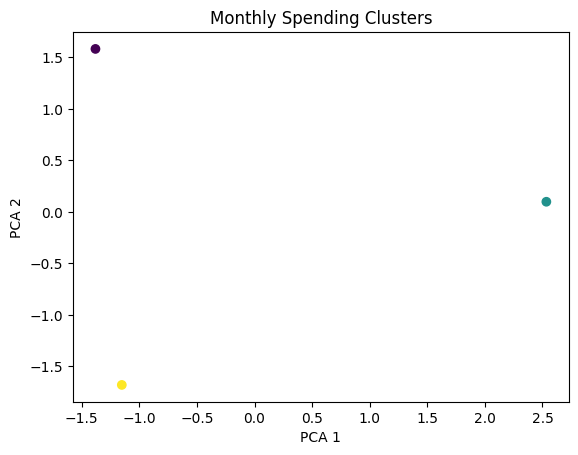

In [14]:
# visualizing the clusters

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.title("Monthly Spending Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


# Monthly Budget Prediction

In [15]:
# total monthly spendings

monthly_total = df.groupby('Month')['Amount'].sum().reset_index()
monthly_total


,Month,Amount
0,2025-01,227
1,2025-02,222
2,2025-03,268


In [16]:
## Convert Month to Numeric for ML

monthly_total['Month_Num'] = range(1, len(monthly_total) + 1)
monthly_total


,Month,Amount,Month_Num
0,2025-01,227,1
1,2025-02,222,2
2,2025-03,268,3


In [17]:
X = monthly_total[['Month_Num']]
y = monthly_total['Amount']                           # preparing futures and targets


In [18]:
# training the regression model

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# Predict Next Month’s Budget

next_month_df = pd.DataFrame({
    'Month_Num': [monthly_total['Month_Num'].max() + 1]
})

predicted_budget = model.predict(next_month_df)

print(f"Estimated next month spending: {predicted_budget[0]:.2f}")


Estimated next month spending: 280.00


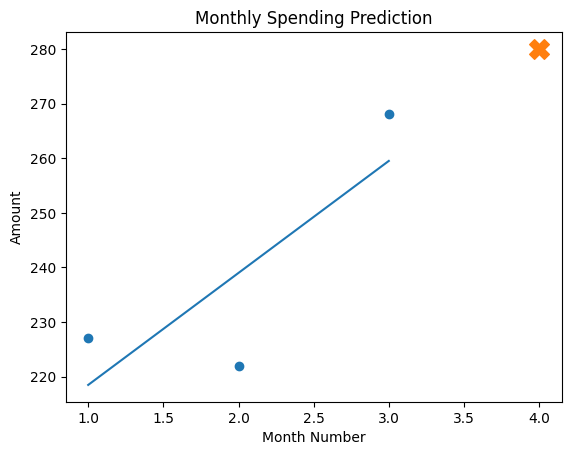

In [21]:
# visualizing the predicted plots
plt.scatter(monthly_total['Month_Num'], y)
plt.plot(monthly_total['Month_Num'], model.predict(X))
plt.scatter(next_month_num, predicted_budget, marker='X', s=200)
plt.title("Monthly Spending Prediction")
plt.xlabel("Month Number")
plt.ylabel("Amount")
plt.show()
